In [47]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from imblearn import over_sampling

In [48]:
#import features for modeling
features = pd.read_csv('Features.csv')

features.columns

Index(['Provider', 'Phys_Count', 'Patient_Count', 'Claim_Count',
       'Service_Type', 'Both_Service', 'Inpatient', 'Outpatient',
       'DuplicateClaims', 'Duplicate_Claims_Percent', 'AvgClaimDuration',
       'Avg_Cost', 'Avg_Age', 'Gender1', 'Gender2', 'Race1', 'Race2', 'Race3',
       'Race5', 'ChronicCond_Alzheimer', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'PotentialFraud', 'NetworkDegree'],
      dtype='object')

In [49]:
features['PotentialFraud'] = features['PotentialFraud'].map({'No': 0, 'Yes': 1})
features.set_index('Provider', inplace=True)

In [50]:
X = features.drop(['PotentialFraud', 'Service_Type', 'Both_Service', 'Gender2'], axis=1)
y = features['PotentialFraud'] 

In [51]:
#train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [52]:
#scale on the training set 
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=(X_train.columns))

In [53]:
#use as cv=skf, ensures results are consistent in each partition
s_kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True);

### Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
plt.style.use('ggplot')

In [45]:
logistic = LogisticRegression(C=1e4, solver = 'liblinear')
logistic.fit(X_train, y_train)
logistic.score(X_test, y_test)

0.8438661710037175

In [46]:
grid_para_logit = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
}
grid_search_logit = ms.GridSearchCV(logistic, grid_para_logit, cv=5, n_jobs=-1)
%time grid_search_logit.fit(X_train, y_train)

CPU times: user 134 ms, sys: 76.5 ms, total: 211 ms
Wall time: 1.01 s


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=10000.0, class_weight=None,
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [47]:
print(grid_search_logit.best_params_)
print(grid_search_logit.best_score_)
logistic_final = grid_search_logit.best_estimator_

{'C': 1}
0.8648598130841123


Feature: Provider , Score: 0.17994
Feature: Phys_Count , Score: 0.06700
Feature: Patient_Count , Score: 0.49772
Feature: Claim_Count , Score: 0.44734
Feature: Both_Service , Score: 0.10968
Feature: Inpatient , Score: 0.42786
Feature: Outpatient , Score: 1.26949
Feature: DuplicateClaims , Score: 0.16693
Feature: Duplicate_Claims_Percent , Score: 0.14598
Feature: AvgClaimDuration , Score: 1.12145
Feature: Avg_Cost , Score: 0.09056
Feature: Avg_Age , Score: 0.44655
Feature: Gender1 , Score: 0.44660
Feature: Gender2 , Score: 0.11468
Feature: Race1 , Score: 0.30068
Feature: Race2 , Score: 0.06121
Feature: Race3 , Score: 0.01731
Feature: Race5 , Score: 0.55288
Feature: ChronicCond_Alzheimer , Score: 0.20396
Feature: ChronicCond_KidneyDisease , Score: 0.47119
Feature: ChronicCond_Cancer , Score: 0.10613
Feature: ChronicCond_ObstrPulmonary , Score: 0.42706
Feature: ChronicCond_Depression , Score: 0.26070
Feature: ChronicCond_Diabetes , Score: 0.00673
Feature: ChronicCond_IschemicHeart , Score:

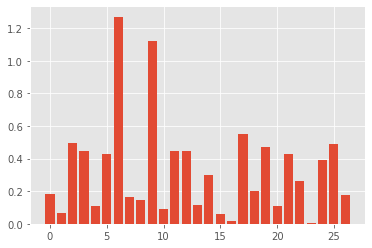

In [51]:
importance = logistic_final.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature:', features.columns[i],', Score: %.5f' % (np.abs(v)))
# plot feature importance
          
plt.bar([x for x in range(len(importance))], np.abs(importance))
plt.show()

In [53]:
# Correlation Matrix 
corr = features.corr().abs()
corr.style.background_gradient(cmap='coolwarm')

,Phys_Count,Patient_Count,Claim_Count,Both_Service,Inpatient,Outpatient,DuplicateClaims,Duplicate_Claims_Percent,AvgClaimDuration,Avg_Cost,Avg_Age,Gender1,Gender2,Race1,Race2,Race3,Race5,ChronicCond_Alzheimer,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,PotentialFraud
Phys_Count,1.000000,0.384567,0.209319,0.248152,0.066006,0.236413,0.250841,0.108740,0.035263,0.048678,0.015180,0.385037,0.383008,0.390418,0.378383,0.144380,0.181182,0.208266,0.207238,0.208960,0.206986,0.208694,0.207699,0.207530,0.208548,0.208812,0.209385,0.199890
Patient_Count,0.384567,1.000000,0.946559,0.008841,0.055238,0.001127,0.927216,0.093066,0.082485,0.103278,0.024236,0.997551,0.998661,0.996267,0.858958,0.680021,0.692500,0.946708,0.945466,0.946904,0.945438,0.946421,0.946478,0.945407,0.945995,0.946425,0.946477,0.395636
Claim_Count,0.209319,0.946559,1.000000,0.018963,0.045696,0.027228,0.967189,0.096760,0.099968,0.126959,0.011231,0.944165,0.945348,0.939714,0.771102,0.716160,0.718252,0.999777,0.999736,0.999929,0.999762,0.999797,0.999797,0.999758,0.999859,0.999861,0.999937,0.378776
Both_Service,0.248152,0.008841,0.018963,1.000000,0.094221,0.983709,0.009379,0.025536,0.373727,0.465319,0.018036,0.010407,0.007656,0.008597,0.013360,0.000847,0.006670,0.021500,0.023735,0.019608,0.022851,0.019524,0.022345,0.022561,0.019404,0.020470,0.019957,0.318173
Inpatient,0.066006,0.055238,0.045696,0.094221,1.000000,0.086285,0.044971,0.020598,0.336833,0.410186,0.065048,0.055596,0.054799,0.055603,0.048743,0.032661,0.030798,0.046014,0.046364,0.045784,0.046035,0.045920,0.046224,0.045969,0.045658,0.046098,0.045825,0.052668
Outpatient,0.236413,0.001127,0.027228,0.983709,0.086285,1.000000,0.017506,0.029274,0.434821,0.539724,0.006303,0.000376,0.002234,0.001437,0.004568,0.006745,0.001114,0.029825,0.032125,0.027890,0.031180,0.027830,0.030708,0.030878,0.027663,0.028809,0.028247,0.327913
DuplicateClaims,0.250841,0.927216,0.967189,0.009379,0.044971,0.017506,1.000000,0.055468,0.092805,0.118094,0.009316,0.922376,0.927874,0.924518,0.770413,0.645991,0.674168,0.966735,0.967008,0.966935,0.966548,0.967048,0.966075,0.965763,0.967246,0.967015,0.966516,0.350021
Duplicate_Claims_Percent,0.108740,0.093066,0.096760,0.025536,0.020598,0.029274,0.055468,1.000000,0.055112,0.041501,0.012086,0.097613,0.089410,0.090961,0.077811,0.100676,0.038223,0.097723,0.097393,0.097755,0.097821,0.097633,0.099122,0.098745,0.096578,0.097415,0.097414,0.105001
AvgClaimDuration,0.035263,0.082485,0.099968,0.373727,0.336833,0.434821,0.092805,0.055112,1.000000,0.795650,0.054144,0.079990,0.084070,0.084503,0.069247,0.040220,0.039837,0.103219,0.105680,0.100990,0.104444,0.102047,0.103991,0.103830,0.100710,0.101672,0.101595,0.305476
Avg_Cost,0.048678,0.103278,0.126959,0.465319,0.410186,0.539724,0.118094,0.041501,0.795650,1.000000,0.071142,0.100905,0.104709,0.105123,0.089510,0.051343,0.054969,0.130430,0.133362,0.128309,0.132133,0.129466,0.131332,0.131309,0.127905,0.128947,0.128792,0.387022


### Stochastic Gradient Descent Classifier

In [54]:
from sklearn.linear_model import SGDClassifier

In [55]:
sgd = SGDClassifier(loss='log', max_iter=1e4, l1_ratio=0, alpha=1e-4, shuffle=False)
grid_para_sgd = {
    'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'alpha': np.linspace(1e-3,200,30)
}
grid_search_sgd = ms.GridSearchCV(sgd, grid_para_sgd, cv=5, n_jobs=-1)
%time grid_search_sgd.fit(X_train, y_train)

CPU times: user 1.06 s, sys: 84.2 ms, total: 1.14 s
Wall time: 2 s


GridSearchCV(cv=5, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0, learning_rate='optimal',
                                     loss='log', max_iter=10000.0,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=False,
                                     tol=0.001, validation_fraction=0.1,
                                     v...
       8.27592069e+01, 8.96557241e+01, 9.65522414e+01, 1.03448759e+02,
       1.10345276e+02, 1.17241793e+02, 1.24138310e+02, 1.31034828e+02,
       1.37931345e+02, 1.44827862e+02, 1.51724379e+02, 1.58620897e+02,
       1.65517414e+02, 1.72413931e+02, 1.79310448e+02, 1.86206966e

In [56]:
print(grid_search_sgd.best_params_)
print(grid_search_sgd.best_score_)
sgd_final = grid_search_sgd.best_estimator_

{'alpha': 0.001, 'max_iter': 100}
0.8527276678982829


Feature: Provider , Score: 0.19682
Feature: Phys_Count , Score: 0.09866
Feature: Patient_Count , Score: 0.51886
Feature: Claim_Count , Score: 0.47396
Feature: Both_Service , Score: 0.28834
Feature: Inpatient , Score: 0.42224
Feature: Outpatient , Score: 1.44700
Feature: DuplicateClaims , Score: 0.13545
Feature: Duplicate_Claims_Percent , Score: 0.11690
Feature: AvgClaimDuration , Score: 1.23176
Feature: Avg_Cost , Score: 0.03703
Feature: Avg_Age , Score: 0.45845
Feature: Gender1 , Score: 0.16774
Feature: Gender2 , Score: 0.11716
Feature: Race1 , Score: 0.12038
Feature: Race2 , Score: 0.12632
Feature: Race3 , Score: 0.09453
Feature: Race5 , Score: 0.54736
Feature: ChronicCond_Alzheimer , Score: 0.19526
Feature: ChronicCond_KidneyDisease , Score: 0.44693
Feature: ChronicCond_Cancer , Score: 0.22076
Feature: ChronicCond_ObstrPulmonary , Score: 0.57902
Feature: ChronicCond_Depression , Score: 0.37209
Feature: ChronicCond_Diabetes , Score: 0.07556
Feature: ChronicCond_IschemicHeart , Score:

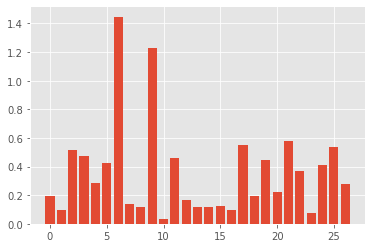

In [57]:
importance = sgd_final.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature:', features.columns[i],', Score: %.5f' % (np.abs(v)))
# plot feature importance
          
plt.bar([x for x in range(len(importance))], np.abs(importance))
plt.show()

### K-Nearest Neighbors

In [67]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn.fit(X_test, y_test)

KNeighborsClassifier()

In [68]:
#upsampling for KNN 
oversample = over_sampling.SMOTE()
X_train_knn, y_train_knn = oversample.fit_resample(X_train, y_train)

y_train_knn.value_counts()

1    841
0    841
Name: PotentialFraud, dtype: int64

In [69]:
# baseline recall score
knn_train_recall = recall_score(y_train_knn, knn.predict(X_train_knn))
knn_test_recall = recall_score(y_test, knn.predict(X_test))

print('Train Set Recall Score:', knn_train_recall)
print('Test Set Recall Score:', knn_test_recall)

Train Set Recall Score: 0.5065398335315101
Test Set Recall Score: 0.5344827586206896


In [70]:
# grid search
params = {'n_neighbors': [25, 50, 75, 100, 125, 150, 200]}

knn_GS =  GridSearchCV(knn, param_grid = params,
                       cv=s_kf, n_jobs=(-1), verbose = 1,
                       return_train_score = True,
                       scoring = 'recall')

knn_GS.fit(X_train_knn, y_train_knn)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [25, 50, 75, 100, 125, 150, 200]},
             return_train_score=True, scoring='recall', verbose=1)

In [71]:
print(knn_GS.best_params_)
print(knn_GS.best_score_)
best_knn = knn_GS.best_estimator_

{'n_neighbors': 125}
0.8609256128486897


In [72]:
# new score
bestknn_train_recall = recall_score(y_train_knn, best_knn.predict(X_train_knn))
bestknn_test_recall  = recall_score(y_test, best_knn.predict(X_test))

print('Train Set Recall Score:', bestknn_train_recall)
print('Test Set Recall Score:', bestknn_test_recall)

Train Set Recall Score: 0.8644470868014269
Test Set Recall Score: 0.8103448275862069


In [73]:
confusion_matrix(y_train_knn, best_knn.predict(X_train_knn))

array([[683, 158],
       [114, 727]])

### Support Vector Machine

In [36]:
svm = SVC(class_weight='balanced')
svm.fit(X_train, y_train)
svm.fit(X_test, y_test)

SVC(class_weight='balanced')

In [37]:
# baseline score
svm_train_recall = recall_score(y_train, svm.predict(X_train))
svm_test_recall = recall_score(y_test, svm.predict(X_test))

print('Train Set Recall Score:', svm_train_recall)
print('Test Set Recall Score:', svm_test_recall)

Train Set Recall Score: 0.8793103448275862
Test Set Recall Score: 0.8103448275862069


In [ ]:
# grid search 
# params = {'C':np.logspace(-1,2,60), 
#           'kernel': ('linear', 'poly', 'rbf'),
#           'gamma':('auto', 'scale'),
#           'degree': [1,3,5]}

In [ ]:
# grid search 
params = {'C':np.logspace(-1,2,60), 
          'kernel': ['linear'],
          'gamma':('auto', 'scale')}

svm_GS =  GridSearchCV(svm, params, cv=s_kf, n_jobs=(-1), verbose = 1, return_train_score = True, scoring = 'recall')
svm_GS.fit(X_train, y_train)

In [ ]:
svm_index =  svm_GS.support_ #index of support vector
print('Index of support vector:' + str(svm_index))

support = svm_GS.support_vectors_ #value of support vector
print(support)

In [ ]:
print(svm_GS.best_params_)
print(svm_GS.best_score_)

In [ ]:
best_svm = svm_GS.best_estimator_

bestsvm_train_recall = recall_score(y_train, bestsvm.predict(X_train))
bestsvm_test_recall = recall_score(y_test, bestsvm.predict(X_test))

print('Train Set Recall Score:', bestsvm_train_recall)
print('Test Set Recall Score:', bestsvm_test_recall)

In [ ]:
#recall = TP / (TP+FN) 
confusion_matrix(y_train, best_svm.predict(X_train))